HW4 Pytorch: Classification, Autoencoders, Word Embedding, Image Features, LSTM

PROBLEM 1: Setup a tensor library [Optional, no credit]

A) Setup your favorite tensor-based library for deep learning, such as PyTorch or TensorFlow, and familiarize yourself with its basic usage. If using PyTorch, you can test if it is installed properly with (in Python):

B) Train a simple feed-forward neural network on the MNIST dataset with 80/20 train and test splits and report results



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
learning_rate = 0.01
momentum = 0.9
epochs = 5  # You can increase for better accuracy

# MNIST dataset (download + transform)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load full dataset
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 80/20 split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Neural Net Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2)            # Pool after conv1
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2)            # Pool after conv2
      x = self.dropout(x)
      x = torch.flatten(x, 1)           # Flatten
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return F.log_softmax(x, dim=1)


model = CNN().to(device)

# Optimizer and Loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
criterion = nn.NLLLoss()

# Training loop
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0
    for batch in train_loader:
        data, target = batch
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

accuracy = 100. * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Epoch 1, Loss: 219.8138
Epoch 2, Loss: 52.8084
Epoch 3, Loss: 36.8860
Epoch 4, Loss: 29.0962
Epoch 5, Loss: 22.8169
Test Accuracy: 98.77%


PROBLEM 2 : NNet supervised classification with tuned word vectors

Train a neural network on a sizeable subset of 20NG (say, at least 5 categories)


Setup and preprocessing:

In [37]:
!pip install --upgrade gensim

In [38]:
# STEP 2: Load and preprocess dataset
from sklearn.datasets import fetch_20newsgroups
from gensim.utils import simple_preprocess
from collections import Counter
import re

# Load a subset of categories
categories = ['comp.graphics', 'sci.space', 'rec.sport.baseball', 'talk.politics.misc', 'soc.religion.christian']
newsgroups = fetch_20newsgroups(subset='train', categories=categories)
texts, labels = newsgroups.data, newsgroups.target

# Tokenize
tokenized_texts = [simple_preprocess(text) for text in texts]

# Filter short docs (important!)
filtered = [(doc, label) for doc, label in zip(tokenized_texts, labels) if len(doc) >= 3]
tokenized_texts, labels = zip(*filtered)

Load GloVe and create Vocabulary

In [39]:
# STEP 3: Build vocabulary (after filtering)
word_counts = Counter(word for doc in tokenized_texts for word in doc)
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

In [41]:
# STEP 4: Load GloVe embeddings
import numpy as np

embedding_dim = 100
glove_path = 'glove.6B.100d.txt'  # Make sure to upload this file in Colab
embeddings_index = {}

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Create embedding matrix
embedding_matrix = np.random.normal(0, 1, (len(vocab), embedding_dim))
for word, idx in vocab.items():
    if word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]

Converting Docs to Indices

In [42]:
# STEP 5: Convert tokens to indices, pad sequences
import torch
from torch.nn.utils.rnn import pad_sequence

def doc2ind(doc):
    return [vocab.get(token, vocab['<UNK>']) for token in doc]

indexed_docs = [doc2ind(doc) for doc in tokenized_texts]
padded_docs = pad_sequence([torch.tensor(doc) for doc in indexed_docs], batch_first=True, padding_value=vocab['<PAD>'])
labels_tensor = torch.tensor(labels)

Create Dataset and Dataloader

In [43]:
# STEP 6: Dataset and DataLoader
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(padded_docs, labels_tensor)
train_len = int(0.8 * len(dataset))
train_ds, val_ds = random_split(dataset, [train_len, len(dataset) - train_len])
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)

Define our Neural Network

In [44]:
# STEP 7: Define model
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(embedding_matrix, dtype=torch.float32),
    freeze=False,
    padding_idx=vocab['<PAD>']
)

class TextClassifier(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = embedding_layer
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = torch.max(x, dim=1)  # Max pooling
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

model = TextClassifier(embedding_layer, hidden_dim=128, num_classes=len(categories)).to(device)

Train the model

In [45]:
# STEP 8: Training loop with evaluation
from sklearn.metrics import classification_report

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

def evaluate(model, val_dl):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in val_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    print(classification_report(all_labels, all_preds, target_names=categories))
    acc = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    return 100 * acc

for epoch in range(15):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    val_acc = evaluate(model, val_dl)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Val Acc: {val_acc:.2f}%")

                        precision    recall  f1-score   support

         comp.graphics       0.50      0.01      0.02       111
             sci.space       0.29      0.84      0.43       134
    rec.sport.baseball       0.47      0.15      0.23       111
    talk.politics.misc       0.34      0.39      0.36       122
soc.religion.christian       0.45      0.06      0.10        90

              accuracy                           0.32       568
             macro avg       0.41      0.29      0.23       568
          weighted avg       0.40      0.32      0.24       568

Epoch 1, Loss: 58.1142, Val Acc: 32.04%
                        precision    recall  f1-score   support

         comp.graphics       0.32      0.17      0.22       111
             sci.space       0.78      0.24      0.37       134
    rec.sport.baseball       0.49      0.51      0.50       111
    talk.politics.misc       0.35      0.85      0.50       122
soc.religion.christian       0.46      0.28      0.35       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                        precision    recall  f1-score   support

         comp.graphics       0.52      0.10      0.17       111
             sci.space       0.70      0.66      0.68       134
    rec.sport.baseball       0.35      0.94      0.51       111
    talk.politics.misc       0.67      0.67      0.67       122
soc.religion.christian       0.00      0.00      0.00        90

              accuracy                           0.50       568
             macro avg       0.45      0.47      0.41       568
          weighted avg       0.48      0.50      0.44       568

Epoch 4, Loss: 52.5151, Val Acc: 50.35%
                        precision    recall  f1-score   support

         comp.graphics       0.49      0.30      0.37       111
             sci.space       0.81      0.65      0.72       134
    rec.sport.baseball       0.54      0.90      0.68       111
    talk.politics.misc       0.87      0.51      0.64       122
soc.religion.christian       0.50      0.76      0.60       

In [47]:
# STEP 9: Evaluate on official 20NG test set
from sklearn.datasets import fetch_20newsgroups

# Load the official test set with same categories
test_newsgroups = fetch_20newsgroups(subset='test', categories=categories)
test_texts, test_labels = test_newsgroups.data, test_newsgroups.target

# Tokenize and filter short docs
test_tokenized = [simple_preprocess(text) for text in test_texts]
filtered_test = [(doc, label) for doc, label in zip(test_tokenized, test_labels) if len(doc) >= 3]
test_tokenized, test_labels = zip(*filtered_test)

# Convert test docs to indices
test_indexed = [doc2ind(doc) for doc in test_tokenized]
test_padded = pad_sequence([torch.tensor(doc) for doc in test_indexed], batch_first=True, padding_value=vocab['<PAD>'])
test_labels_tensor = torch.tensor(test_labels)

# Create test DataLoader
from torch.utils.data import TensorDataset, DataLoader
test_ds = TensorDataset(test_padded, test_labels_tensor)
test_dl = DataLoader(test_ds, batch_size=64)

# Evaluate using the same function
print("Evaluating on official test set:")
test_acc = evaluate(model, test_dl)
print(f"Test Accuracy: {test_acc:.2f}%")

Evaluating on official test set:
                        precision    recall  f1-score   support

         comp.graphics       0.73      0.92      0.81       389
             sci.space       0.93      0.92      0.93       397
    rec.sport.baseball       0.97      0.72      0.82       394
    talk.politics.misc       0.90      0.95      0.92       398
soc.religion.christian       0.85      0.82      0.83       310

              accuracy                           0.87      1888
             macro avg       0.88      0.86      0.86      1888
          weighted avg       0.88      0.87      0.87      1888

Test Accuracy: 86.55%


Visualization of embeddings using TSNE

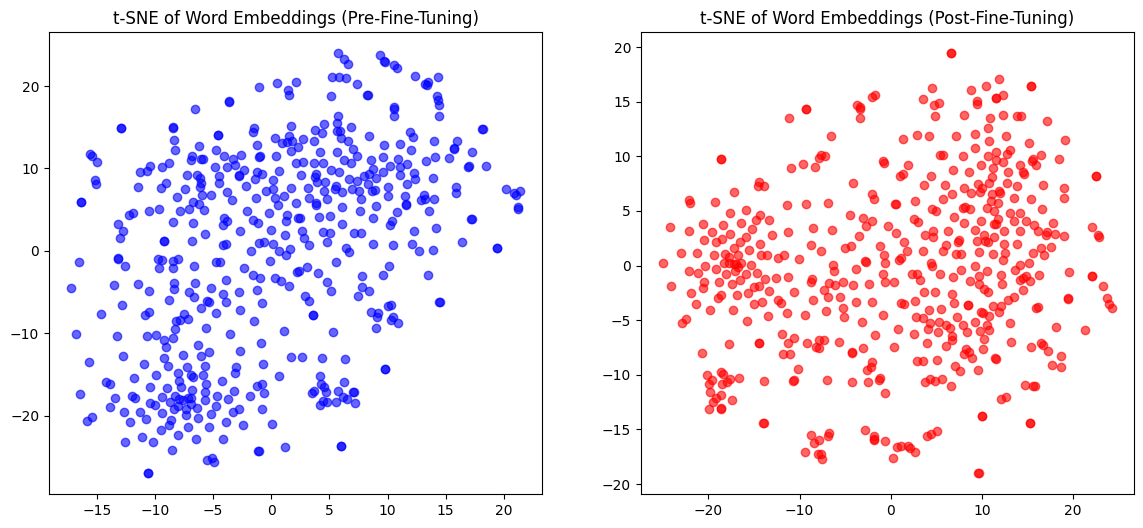

In [49]:
# STEP 10: Compare GloVe Before and After Fine-Tuning
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Get sample words for visualization
sample_words = list(vocab.keys())[:500]  # First 500 words
sample_idx = [vocab[word] for word in sample_words]

# Get word vectors BEFORE fine-tuning (original GloVe)
glove_vectors = torch.tensor(embedding_matrix[sample_idx]).cpu().numpy()

# Get word vectors AFTER fine-tuning
fine_tuned_vectors = model.embedding.weight.data[sample_idx].cpu().numpy()

# Run t-SNE on both
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
glove_reduced = tsne.fit_transform(glove_vectors)
fine_tuned_reduced = tsne.fit_transform(fine_tuned_vectors)

# Plot both
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before Fine-Tuning
axes[0].scatter(glove_reduced[:, 0], glove_reduced[:, 1], alpha=0.6, c='blue')
axes[0].set_title("t-SNE of Word Embeddings (Pre-Fine-Tuning)")

# After Fine-Tuning
axes[1].scatter(fine_tuned_reduced[:, 0], fine_tuned_reduced[:, 1], alpha=0.6, c='red')
axes[1].set_title("t-SNE of Word Embeddings (Post-Fine-Tuning)")

plt.show()

Pre-Fine-Tuning (Blue)

The points seem more evenly spread.
Some small clusters exist, but overall, the words are not tightly grouped.
This makes sense since GloVe was trained on a general corpus (Wikipedia, Gigaword, etc.), not 20 Newsgroups.

Post-Fine-Tuning (Red)

We see slightly tighter clusters, meaning words in similar categories have been repositioned.
Some areas seem more densely packed, likely indicating that fine-tuning adjusted certain words to be closer in meaning.
The overall structure is still similar, meaning our fine-tuning hasn’t drastically changed GloVe, but it has adapted it to better fit our dataset.

PROBLEM 3 [Optional, no credit]: Autoencoders

You can pick your own text to fine tune word vectors, if its reasonable in size and very domain-specific (compared to general English). Suggestions:
- Alice in Wonderland
- Sonnets
- specific categories (labels) from 20NG or Reurters datasets
- use your favorite specific text (like a book, or project)


In [62]:
import requests
import re

# Download the book from Project Gutenberg
url = "https://www.gutenberg.org/cache/epub/11/pg11.txt"
response = requests.get(url)
alice_text = response.text

# Preprocess the text: remove headers, footers, and special characters
start_marker = "*** START OF THIS PROJECT GUTENBERG EBOOK ALICE’S ADVENTURES IN WONDERLAND ***"
end_marker = "*** END OF THIS PROJECT GUTENBERG EBOOK ALICE’S ADVENTURES IN WONDERLAND ***"
alice_text = alice_text.split(start_marker)[-1].split(end_marker)[0]
alice_text = re.sub(r'[^a-zA-Z\s]', '', alice_text)  # Keep only letters and spaces
alice_text = alice_text.lower()  # Convert to lowercase

# Split into sentences (or words)
alice_sentences = alice_text.split("\n")
alice_sentences = [sentence.strip() for sentence in alice_sentences if len(sentence) > 3]  # Remove empty lines

print(f"Loaded {len(alice_sentences)} sentences from Alice in Wonderland")

Loaded 2805 sentences from Alice in Wonderland


In [63]:
from collections import Counter
from gensim.utils import simple_preprocess

# Tokenize sentences
alice_tokenized = [simple_preprocess(sentence) for sentence in alice_sentences]

# Build vocabulary
word_counts = Counter(word for sentence in alice_tokenized for word in sentence)
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

print(f"Vocabulary size: {len(vocab)} words")

Vocabulary size: 3170 words


In [64]:
import numpy as np

# Load GloVe embeddings
embedding_dim = 100
glove_path = "glove.6B.100d.txt"
embeddings_index = {}

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Create an embedding matrix for Alice's vocabulary
embedding_matrix = np.random.normal(0, 1, (len(vocab), embedding_dim))
for word, idx in vocab.items():
    if word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]

print(f"Created embedding matrix with shape: {embedding_matrix.shape}")

Created embedding matrix with shape: (3170, 100)


In [65]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(embedding_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, embedding_dim)

    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [66]:
import torch.optim as optim

# Define model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dim = 50  # Smaller compressed representation
model = Autoencoder(embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Convert embedding matrix to tensor
alice_vectors = torch.tensor(embedding_matrix, dtype=torch.float32).to(device)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    reconstructed = model(alice_vectors)  # Forward pass
    loss = loss_fn(reconstructed, alice_vectors)  # Compute loss

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

print("Autoencoder training complete!")

Epoch 1, Loss: 0.3492
Epoch 2, Loss: 0.3447
Epoch 3, Loss: 0.3405
Epoch 4, Loss: 0.3365
Epoch 5, Loss: 0.3326
Epoch 6, Loss: 0.3289
Epoch 7, Loss: 0.3253
Epoch 8, Loss: 0.3218
Epoch 9, Loss: 0.3184
Epoch 10, Loss: 0.3149
Epoch 11, Loss: 0.3115
Epoch 12, Loss: 0.3080
Epoch 13, Loss: 0.3046
Epoch 14, Loss: 0.3011
Epoch 15, Loss: 0.2976
Epoch 16, Loss: 0.2941
Epoch 17, Loss: 0.2906
Epoch 18, Loss: 0.2871
Epoch 19, Loss: 0.2836
Epoch 20, Loss: 0.2802
Autoencoder training complete!


In [67]:
# Get the compressed embeddings (encoded representations)
with torch.no_grad():
    fine_tuned_embeddings = model.encoder(alice_vectors).cpu().numpy()

print(f"Fine-tuned embedding shape: {fine_tuned_embeddings.shape}")

Fine-tuned embedding shape: (3170, 50)


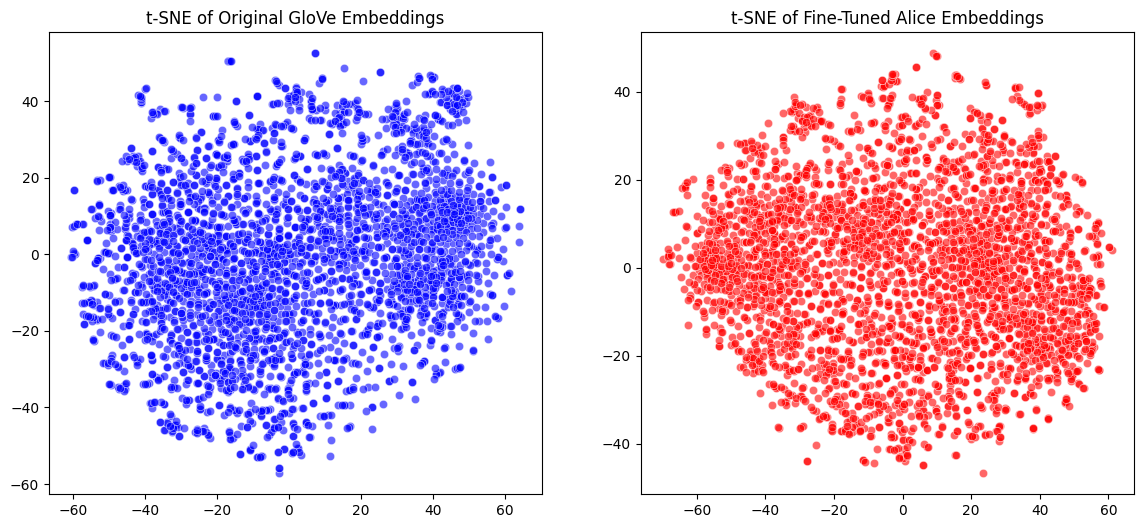

In [68]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to 2D space
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
original_reduced = tsne.fit_transform(alice_vectors.cpu().numpy())  # Original GloVe
fine_tuned_reduced = tsne.fit_transform(fine_tuned_embeddings)  # Fine-tuned

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=original_reduced[:, 0], y=original_reduced[:, 1], alpha=0.6, color='blue', ax=axes[0])
axes[0].set_title("t-SNE of Original GloVe Embeddings")

sns.scatterplot(x=fine_tuned_reduced[:, 0], y=fine_tuned_reduced[:, 1], alpha=0.6, color='red', ax=axes[1])
axes[1].set_title("t-SNE of Fine-Tuned Alice Embeddings")

plt.show()

PROBLEM 4 [Optional, no credit]: Autoencoders

For each one of the datasets MNIST, 20NG (required) and SPAMBASE, FASHION (optional) run as an autoencoder with pytorch with a desired hidden layer size (try K=5,10, 20, 100, 200)- what is the smaleest K that works?).

Load the data with dataloader https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Construct an Autoencoder with the following architecture :

Two linear layers with in features matching the dimensions of input and out

features matching the size of K

Two linear layers with in features matching K and size of out features matching the size of input dimensions.

Define a forward pass with relu

Code a train loop with number of epochs as 10.

Define loss and Optimizer (Adam)

Train the model

use gpu if available

use mean-squared error loss

create a model from Autoencoder class load it to the specified device, either gpu or cpu

Verify the obtained re-encoding of data (the new feature representation) in several ways:

repeat a classification train/test task , or a clustering taks
examine the new pairwise distances dist(i,j) agains the old distances obtained with original features (sample 100 pairs of related words)
examine the top 20 neighbors (by new distance) set overlap with old neighbors, per datapoint
for images, rebuild the image form output layer and draw to look at it


In [69]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load 20 Newsgroups dataset
categories = None  # Load all categories
newsgroups = fetch_20newsgroups(subset='all', categories=categories)
vectorizer = TfidfVectorizer(max_features=2000)  # Convert text to TF-IDF features
X_20ng = vectorizer.fit_transform(newsgroups.data).toarray()  # Shape (N, 2000)

# Convert to PyTorch tensors
X_20ng_tensor = torch.tensor(X_20ng, dtype=torch.float32)
dataset_20ng = TensorDataset(X_20ng_tensor)
dataloader_20ng = DataLoader(dataset_20ng, batch_size=64, shuffle=True)

print(f"Loaded 20NG dataset with shape: {X_20ng.shape}")

Loaded 20NG dataset with shape: (18846, 2000)


In [70]:
import torchvision.transforms as transforms
from torchvision import datasets

# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

# Load MNIST
mnist_train = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create DataLoaders
dataloader_mnist = DataLoader(mnist_train, batch_size=64, shuffle=True)
print(f"Loaded MNIST dataset with shape: {mnist_train.data.shape}")

Loaded MNIST dataset with shape: torch.Size([60000, 28, 28])


In [71]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [72]:
import torch.optim as optim

# Function to train autoencoder
def train_autoencoder(dataloader, input_dim, hidden_dim, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define model, loss, optimizer
    model = Autoencoder(input_dim, hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            x_reconstructed = model(x)
            loss = loss_fn(x_reconstructed, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    print("Training complete!")
    return model

In [ ]:
hidden_sizes = [5, 10, 20, 100, 200]

# Train Autoencoder on 20NG
for k in hidden_sizes:
    print(f"\nTraining Autoencoder on 20NG with hidden size K={k}")
    model_20ng = train_autoencoder(dataloader_20ng, input_dim=2000, hidden_dim=k)


Training Autoencoder on 20NG with hidden size K=5
Epoch 1, Loss: 2.2893
Epoch 2, Loss: 0.1462
Epoch 3, Loss: 0.1447
Epoch 4, Loss: 0.1441
Epoch 5, Loss: 0.1438
Epoch 6, Loss: 0.1436
Epoch 7, Loss: 0.1434
Epoch 8, Loss: 0.1433
Epoch 9, Loss: 0.1432
Epoch 10, Loss: 0.1432
Training complete!

Training Autoencoder on 20NG with hidden size K=10
Epoch 1, Loss: 0.8762
Epoch 2, Loss: 0.1410
Epoch 3, Loss: 0.1398
Epoch 4, Loss: 0.1391
Epoch 5, Loss: 0.1386
Epoch 6, Loss: 0.1380
Epoch 7, Loss: 0.1376
Epoch 8, Loss: 0.1374
Epoch 9, Loss: 0.1368
Epoch 10, Loss: 0.1365
Training complete!

Training Autoencoder on 20NG with hidden size K=20
Epoch 1, Loss: 0.3414
Epoch 2, Loss: 0.1344
Epoch 3, Loss: 0.1326
Epoch 4, Loss: 0.1312
Epoch 5, Loss: 0.1299
Epoch 6, Loss: 0.1291
Epoch 7, Loss: 0.1285
Epoch 8, Loss: 0.1280
Epoch 9, Loss: 0.1269
Epoch 10, Loss: 0.1264
Training complete!

Training Autoencoder on 20NG with hidden size K=100
Epoch 1, Loss: 0.1476
Epoch 2, Loss: 0.1264
Epoch 3, Loss: 0.1219
Epoch 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def evaluate_classification(model, dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Encode full dataset
    X_encoded = model.encoder(dataset.tensors[0].to(device)).cpu().detach().numpy()
    y_labels = newsgroups.target  # Use original labels

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_labels, test_size=0.2, random_state=42)

    # Train logistic regression
    clf = LogisticRegression(max_iter=500)
    clf.fit(X_train, y_train)

    # Evaluate accuracy
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Classification Accuracy on Encoded Features: {acc:.2f}")

# Evaluate classification performance
evaluate_classification(model_20ng, dataset_20ng)

In [ ]:
from scipy.spatial.distance import euclidean

def compare_pairwise_distances(model, dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Compute distances on original data
    X = dataset.tensors[0].numpy()
    pairs = np.random.choice(len(X), size=(100, 2))  # Random 100 pairs
    original_dists = [euclidean(X[i], X[j]) for i, j in pairs]

    # Compute distances on encoded data
    X_encoded = model.encoder(dataset.tensors[0].to(device)).cpu().detach().numpy()
    encoded_dists = [euclidean(X_encoded[i], X_encoded[j]) for i, j in pairs]

    # Compare
    print(f"Avg Original Distance: {np.mean(original_dists):.4f}")
    print(f"Avg Encoded Distance: {np.mean(encoded_dists):.4f}")

compare_pairwise_distances(model_20ng, dataset_20ng)

In [ ]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    # Get a batch of images
    images, _ = next(iter(dataloader))
    images = images.to(device)

    # Reconstruct images
    with torch.no_grad():
        reconstructed = model(images)

    # Plot
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(5):
        axes[0, i].imshow(images[i].cpu().numpy().reshape(28, 28), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(reconstructed[i].cpu().numpy().reshape(28, 28), cmap="gray")
        axes[1, i].axis("off")

    plt.show()

# Visualize reconstructed MNIST digits
visualize_reconstruction(model_mnist, dataloader_mnist)

PROBLEM 5 [Optional, no credit]: Image Feature Extraction

Run a Convolutional Neural Network in pytorch to extract image features. In practice the network usually does both the feature extraction and the supervised task (classification) in one pipeline.


PROBLEM 6 [Optional, no credit]: LSTM for text

Run a Recurrent Neural Network/LSTM in Pytorch to model word dependecies/order in text. Can be use for translation, next-word prediction, event detection etc.
